In [1]:
import re

import io
from tqdm import tqdm

import pandas as pd
import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import emoji

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.layers import TextVectorization

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [4]:
def load_glove(fname):
    embeddings_index = {}
    with open(fname, encoding="utf8") as f:
        for line in tqdm(f):
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    
    return embeddings_index

In [5]:
parameters = {}
parameters['embedding_name'] = './embeddings/glove.twitter.27B.100d.txt'
parameters['classes'] = ['anger', 'joy', 'sadness', 'fear']
parameters['save_path'] = 'models/wassa_cnn_lstm/'

In [6]:
embedding_index = load_glove(parameters['embedding_name'])
print('Number of word vectors : ', len(embedding_index))

1193514it [00:50, 23783.10it/s]

Number of word vectors :  1193514


## Reading and Pre-processing

In [7]:
base_path = '../Data/wassa_data/'

In [8]:
class_mapping = {}

for idx, name in enumerate(parameters['classes']):
    class_mapping[name] = idx 
    
no_classes = len(parameters['classes'])

In [9]:
cols = ['tweet', 'tweettype']

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                   "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [11]:
import codecs
import unidecode
import re
import spacy
nlp = spacy.load('en')

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [12]:
def clean_text(data):
    data = (re.sub(r"(#[\d\w\.]+)", '', data)).lower()
    data = emoji.demojize(data)
    data = spacy_cleaner(data)
    return data

In [13]:
def build_dataset(df, feature='text', target='label'):
    dataset = (
                tf.data.Dataset.from_tensor_slices(
                    (
                        tf.cast(df[feature].values, tf.string),
                        tf.cast(df[target].values, tf.int32)
                    )
                )
            )
    return dataset

In [14]:
def load_dataset(directory, ending, threshold = 0, testing = False):

    df_list = []

    for emotion in parameters['classes']:
        file_name = f'{base_path}{directory}/{emotion}{ending}'
        df = pd.read_csv(file_name, delimiter='\t')
        
        if not testing:
            df = df[df['score'] > threshold]
        
        df = df[cols]
        
        df['tweet'] = df['tweet'].apply(clean_text)        
        df['tweettype'] = df['tweettype'].apply(lambda x : class_mapping[x])        

        df_list.append(df)

    df = pd.concat(df_list)
    df = df.rename(columns = {'tweet' : 'text', 'tweettype' : 'label'})
    print('Distribution of data: ')
    print(df['label'].value_counts())
    
    labels = df['label'].values
    
    dataset = build_dataset(df)
    
    return dataset, labels, df

In [15]:
# Training
threshold = 0

directory = 'training'
ending = '-ratings-0to1.train.txt'

train_dataset,_, df_train = load_dataset(directory, ending, threshold = threshold)

Distribution of data: 
3    1147
0     857
1     823
2     786
Name: label, dtype: int64


In [16]:
# Validation

directory = 'validation'
ending = '-ratings-0to1.dev.gold.txt'

val_dataset,_, df_val = load_dataset(directory, ending)

Distribution of data: 
3    110
0     84
1     79
2     74
Name: label, dtype: int64


In [17]:
# Testing

directory = 'testing'
ending = '-ratings-0to1.test.target.txt'

test_dataset, y_test, df_test = load_dataset(directory, ending, testing = True)

Distribution of data: 
3    995
0    760
1    714
2    673
Name: label, dtype: int64


In [18]:
vectorizer = TextVectorization(output_sequence_length=100)
vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [19]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'be', 'the', 'to']

In [20]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [21]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 5663 words (567 misses)


In [22]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [23]:
x_train = vectorizer(np.array([[s] for s in list(df_train.text)])).numpy()
x_val = vectorizer(np.array([[s] for s in list(df_val.text)])).numpy()

y_train = np.array(list(df_train.label)).reshape(-1, 1)
y_val = np.array(list(df_val.label)).reshape(-1, 1)

In [24]:
x_train[0]

array([  53,    3, 2733,   61,    3, 2674,  272,   14, 2739,   96, 1118,
          3, 2570, 1155,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int64)

In [36]:
from tensorflow.keras import layers

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
embedded_sequences.trainable = False 

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedded_sequences)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)

x = layers.Conv1D(128, 2, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(128, 2, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(128, 2, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

preds = layers.Dense(no_classes, activation="softmax")(x)

model = tf.keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         623200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         32896     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         3289

In [26]:
import os
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [35]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class CustomCallback(Callback):
    def __init__(self, validation_data=None):
        super(CustomCallback, self).__init__()
        self.validation_data = validation_data
        
    def on_train_begin(self, logs={}):        
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs={}):        
        val_predict = (np.asarray(self.model.predict(self.validation_data[0])))
        val_predict = [np.argmax(i) for i in val_predict]
        
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average = 'weighted')
        _val_recall = recall_score(val_targ, val_predict, average = 'weighted')
        _val_precision = precision_score(val_targ, val_predict, average = 'weighted')
        
        print("— val_f1: %f — val_precision: %f — val_recall %f"%(_val_f1, _val_precision, _val_recall))
        
        if _val_f1 > self.best_f1:
            make_dir(parameters['save_path'])
            self.model.save_weights(f"{parameters['save_path']}")
            self.best_f1 = _val_f1
            
            print("saving...")
        
        return

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                    batch_size=128, epochs=15, shuffle = True, 
                    callbacks = [CustomCallback(validation_data = (x_val, y_val))])

Epoch 1/15
29/29 [==============================] - 23s 585ms/step - loss: 1.3721 - accuracy: 0.3033 - val_loss: 1.3401 - val_accuracy: 0.3429


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


— val_f1: 0.245678 — val_precision: 0.197187 — val_recall 0.342939
saving...
Epoch 2/15
29/29 [==============================] - 16s 566ms/step - loss: 1.3268 - accuracy: 0.3609 - val_loss: 1.3648 - val_accuracy: 0.4294


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


— val_f1: 0.378753 — val_precision: 0.382276 — val_recall 0.429395
saving...
Epoch 3/15
29/29 [==============================] - 18s 630ms/step - loss: 1.2398 - accuracy: 0.4420 - val_loss: 1.2266 - val_accuracy: 0.4524
— val_f1: 0.416392 — val_precision: 0.445977 — val_recall 0.452450
saving...
Epoch 4/15
29/29 [==============================] - 21s 719ms/step - loss: 1.1608 - accuracy: 0.4979 - val_loss: 1.1743 - val_accuracy: 0.5043
— val_f1: 0.491216 — val_precision: 0.532056 — val_recall 0.504323
saving...
Epoch 5/15
29/29 [==============================] - 22s 746ms/step - loss: 1.0489 - accuracy: 0.5605 - val_loss: 1.1713 - val_accuracy: 0.5014
— val_f1: 0.448059 — val_precision: 0.605317 — val_recall 0.501441
Epoch 6/15
29/29 [==============================] - 21s 743ms/step - loss: 0.9738 - accuracy: 0.5965 - val_loss: 1.0887 - val_accuracy: 0.5130
— val_f1: 0.513468 — val_precision: 0.616967 — val_recall 0.512968
saving...
Epoch 7/15
29/29 [==============================] - 2

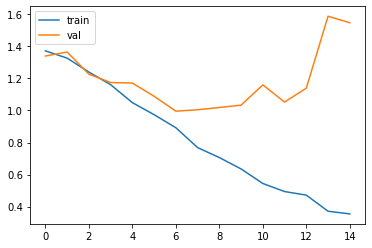

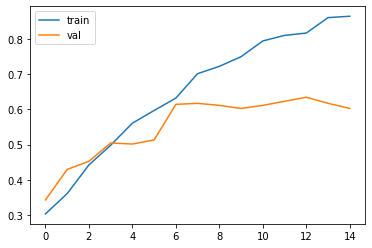

In [38]:
plt.figure(1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

## Evaluation against test

In [39]:
model.load_weights(parameters['save_path'])

In [40]:
x_test = vectorizer(np.array([[s] for s in list(df_test.text)])).numpy()
y_test = np.array(list(df_test.label))

model.evaluate(x_test, y_test)

99/99 [==============================] - 9s 74ms/step - loss: 1.1033 - accuracy: 0.6114


[1.1032707691192627, 0.6113939881324768]

In [41]:
pred = model.predict(x_test)

pred_idx = []

for i in tqdm(range(len(pred))):
    pred_idx.append(np.argmax(pred[i]))

100%|██████████████████████████████████████████████████████████████████████████| 3142/3142 [00:00<00:00, 392719.94it/s]


In [42]:
print(classification_report(y_test, pred_idx, target_names=parameters['classes']))

              precision    recall  f1-score   support

       anger       0.58      0.58      0.58       760
         joy       0.74      0.66      0.69       714
     sadness       0.61      0.54      0.57       673
        fear       0.56      0.65      0.60       995

    accuracy                           0.61      3142
   macro avg       0.62      0.61      0.61      3142
weighted avg       0.62      0.61      0.61      3142



In [43]:
print(confusion_matrix(y_test, pred_idx))

[[444  49  77 190]
 [ 66 468  40 140]
 [101  31 361 180]
 [148  86 113 648]]
